### 05/06/2019 To-do list:
1. Calibration curve analog for regression (edited) 
2. Indicate how many points are below/above each parity line
3. Plot multiple cases side by side on the same graph (e.g. test set with 50 pts & 1500 pts)
4. Manipulating dropout

### 06/14/2019 To-do list:
1. If process gets stuck on SDT transform (tqdm) step:
   a. Cache

This document demonstrates the making, training, saving, loading, and usage of a sklearn-compliant CGCNN model.

In [1]:
%load_ext ipycache

/pylon5/ch5fq5p/zulissi/miniconda3/envs/cgcnn/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/pylon5/ch5fq5p/zulissi/miniconda3/envs/cgcnn/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [2]:
import os
import sys
#Comment/add these
sys.path.insert(0,'../')
sys.path.insert(0,'/home/zulissi/software/adamwr/')

import numpy as np
import cgcnn

import time

#Select which GPU to use if necessary
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


## Load the dataset as mongo docs

In [3]:
import random
import pickle

starttime = time.clock()
#Load a selection of documents
docs = pickle.load(open('/pylon5/ch5fq5p/zulissi/CO_docs.pkl','rb'))
random.seed(42)
random.shuffle(docs)
docs = [doc for doc in docs if -3<doc['energy']<1.0]
docs = docs[:6000]

endtime = time.clock()
print('This operation took', endtime - starttime, 's.')

This operation took 14.73 s.


## Get the size of the features from the data transformer, to be used in setting up the net model

In [4]:
%%cache SDT_list.pkl SDT_list
from torch.utils.data import Dataset, DataLoader
import mongo
from cgcnn.data import StructureData, ListDataset, StructureDataTransformer
import numpy as np
import tqdm
from sklearn.preprocessing import StandardScaler

SDT = StructureDataTransformer(atom_init_loc='../atom_init.json',
                              max_num_nbr=12,
                               step=0.2,
                              radius=1,
                              use_tag=False,
                              use_fixed_info=False,
                              use_distance=True)

SDT_out = SDT.transform(docs)

structures = SDT_out[0]

# Settings necessary to build the model (since they are size of vectors as inputs)
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

import multiprocess as mp
from sklearn.model_selection import ShuffleSplit

SDT_out = SDT.transform(docs)

with mp.Pool(4) as pool:
    SDT_list = list(tqdm.tqdm(pool.imap(lambda x: SDT_out[x],range(len(SDT_out)),chunksize=40),total=len(SDT_out)))


[Skipped the cell's code and loaded variables SDT_list from file '/home/qzhang8/cgcnn/examples/SDT_list.pkl'.]


100%|##########| 6000/6000 [35:51<00:00,  2.79it/s]


In [5]:
starttime = time.clock()
with open('distance_all_docs.pkl','wb') as fhandle:
    pickle.dump(SDT_list,fhandle)

endtime = time.clock()
print('This step took', endtime - starttime, 's to complete.')

This step took 0.9300000000000033 s to complete.


## CGCNN model with skorch to make it sklearn compliant

In [6]:
from torch.optim import Adam, SGD
from sklearn.model_selection import ShuffleSplit
from skorch.callbacks import Checkpoint, LoadInitState #needs skorch 0.4.0, conda-forge version at 0.3.0 doesn't cut it
from cgcnn.data import collate_pool
from skorch import NeuralNetRegressor
from cgcnn.model import CrystalGraphConvNet
import torch
from cgcnn.data import MergeDataset
import skorch.callbacks.base

cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device='cpu'

startime = time.clock()

#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best', fn_prefix='valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
        
load_best_valid_loss = train_end_load_best_valid_loss()

endtime = time.clock()
print('This step takes', endtime - startime, 's to complete.')

This step takes 0.0 s to complete.


<div class="alert alert-block alert-warning">
<b> Issue 1 </b>

This seems to be a very time consuming step (that we haven't skipped)
</div>

## Example converting all the documents up front

In [7]:
starttime = time.clock()
#Make the target list
target_list = np.array([doc['energy'] for doc in docs]).reshape(-1,1)

endtime = time.clock()
print('This step takes', endtime - startime, 's to complete.')

This step takes 0.030000000000001137 s to complete.


## Shuffle and Split

In [8]:
from sklearn.model_selection import train_test_split

starttime = time.clock()
SDT_training, SDT_test, target_training, target_test = train_test_split(SDT_list, target_list, test_size=0.2)

endtime = time.clock()
print('This step takes', endtime - startime, 's to complete.')


This step takes 0.03999999999999915 s to complete.


# Fit the model

In [9]:
from skorch.dataset import CVSplit
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler

train_test_splitter = ShuffleSplit(test_size=0.25, random_state=42)
LR_schedule = LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len = orig_atom_fea_len,
    module__nbr_fea_len = nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=188, # 292
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn = collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    device=device,
    criterion=torch.nn.MSELoss,
#   criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    train_split = CVSplit(cv=train_test_splitter),
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

NameError: name 'orig_atom_fea_len' is not defined

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot(SDT_training, SDT_test, target_training, target_test, net):
    train_test_splitter = ShuffleSplit(test_size=0.25, random_state=42)
    train_indices, valid_indices = next(train_test_splitter.split(SDT_training))
    # lentotal = len(SDT_training)
    # train_indices = list(range(round(3/4 * lentotal)))
    # valid_indices = list(range(round(3/4 * lentotal), lentotal))

    training_data = {'actual_value':np.array(target_training.reshape(-1))[train_indices],
                     'predicted_value':net.predict(SDT_training)[train_indices].reshape(-1)}
    test_data = {'actual_value':np.array(target_test).reshape(-1),
                 'predicted_value':net.predict(SDT_test).reshape(-1)}
    validation_data = {'actual_value':np.array(target_training.reshape(-1))[valid_indices],
                       'predicted_value':net.predict(SDT_training)[valid_indices].reshape(-1)}

    df_training = pd.DataFrame(training_data)
    df_validation = pd.DataFrame(validation_data)
    df_test = pd.DataFrame(test_data)
    
    f, ax = plt.subplots(figsize=(8,8))
    ax.scatter(df_training['actual_value'], df_training['predicted_value'], color='orange', 
               marker='o', alpha=0.5, label='train\nMAE=%0.2f, RMSE=%0.2f, R$^2$=%0.2f'\
                %(mean_absolute_error(df_training['actual_value'], df_training['predicted_value']), 
                  np.sqrt(mean_squared_error(df_training['actual_value'], df_training['predicted_value'])),
                  r2_score(df_training['actual_value'], df_training['predicted_value'])))

    ax.scatter(df_validation['actual_value'], df_validation['predicted_value'], color='blue', 
               marker='o', alpha=0.5, label='valid\nMAE=%0.2f, RMSE=%0.2f, R$^2$=%0.2f'\
                %(mean_absolute_error(df_validation['actual_value'], df_validation['predicted_value']), 
                  np.sqrt(mean_squared_error(df_validation['actual_value'], df_validation['predicted_value'])),
                  r2_score(df_validation['actual_value'], df_validation['predicted_value'])))

    ax.scatter(df_test['actual_value'], df_test['predicted_value'], color='green', 
               marker='o', alpha=0.5, label='test\nMAE=%0.2f, RMSE=%0.2f, R$^2$=%0.2f'\
                %(mean_absolute_error(df_test['actual_value'], df_test['predicted_value']), 
                  np.sqrt(mean_squared_error(df_test['actual_value'], df_test['predicted_value'])),
                  r2_score(df_test['actual_value'], df_test['predicted_value'])))

    ax.plot([min(df_training['actual_value']), max(df_training['actual_value'])], 
            [min(df_training['actual_value']), max(df_training['actual_value'])], 'k--')

    # format graph
    ax.tick_params(labelsize=14)
    ax.set_xlabel('DFT E (eV)', fontsize=14)
    ax.set_ylabel('CGCNN predicted E (eV)', fontsize=14)
    ax.set_title('Multi-element ', fontsize=14) 
    ax.legend(fontsize=12)

    plt.show()
    
    return df_training, df_validation, df_test

In [ ]:
TrainingData = []
ValidationData = []
TestData = []

iters = 7

starttime = time.clock()

net.initialize()
net.fit(SDT_training, target_training)

for i in range(iters):
    # net()
    # net.initialize()
    # net.fit(SDT_training, target_training)
    
    # print(SDT_training, SDT_test, target_training, target_test)
    
    dftraining, dfvalidation, dftest = plot(SDT_training,
                                            SDT_test,
                                            target_training,
                                            target_test, net)
    
    TrainingData.append(dftraining)
    ValidationData.append(dfvalidation)
    TestData.append(dftest)
    
TrainingData = pd.concat(TrainingData, axis=1)
ValidationData = pd.concat(ValidationData, axis=1)
TestData = pd.concat(TestData, axis=1)

endtime = time.clock()
print("Calculating the same points {} times takes {} s.".format(iters, endtime-starttime))

In [ ]:
"""
# The d20 suffix means a droupout of 20% is applied
TrainingData.to_pickle('TrData_7iters_d20.pkl')
ValidationData.to_pickle('VlData_7iters_d20.pkl')
TestData.to_pickle('TsData_7iters_d20.pkl')
"""

In [ ]:
# The d30 suffix means a droupout of 30% is applied
TrainingData.to_pickle('TrData_7iters_d30.pkl')
ValidationData.to_pickle('VlData_7iters_d30.pkl')
TestData.to_pickle('TsData_7iters_d30.pkl')


In [1]:
TrainingData.to_pickle('TrData_10iters.pkl')
ValidationData.to_pickle('VlData_10iters.pkl')
TestData.to_pickle('TsData_10iters.pkl')


NameError: name 'TrainingData' is not defined

## Extracting Pickle File and Plotting

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

TrainingData = pd.read_pickle('TrData_7iters_vanilla.pkl')
ValidationData = pd.read_pickle('VlData_7iters_vanilla.pkl')
TestData = pd.read_pickle('TsData_7iters_vanilla.pkl')

print('no-dropout section of data reading completed')

# With dropout applied
dTrainingData = pd.read_pickle('TrData_7iters_d30.pkl')
dValidationData = pd.read_pickle('VlData_7iters_d30.pkl')
dTestData = pd.read_pickle('TsData_7iters_d30.pkl')
"""
dTrainingData = pd.read_pickle('TrData_7iters_d20.pkl')
dValidationData = pd.read_pickle('VlData_7iters_d20.pkl')
dTestData = pd.read_pickle('TsData_7iters_d20.pkl')
"""

print('dropout section of data reading completed')


no-dropout section of data reading completed
dropout section of data reading completed


In [2]:
TrainingMean = TrainingData['predicted_value'].mean(axis=1)
TrainingSTD  = TrainingData['predicted_value'].std(axis=1)
TestMean     = TestData['predicted_value'].mean(axis=1)
TestSTD      = TestData['predicted_value'].std(axis=1)

TrainingStats = pd.concat([TrainingMean, TrainingSTD], axis=1)
TestStats     = pd.concat([TestMean, TestSTD], axis=1)
TrainingStats.columns = ['mean', 'std']
TestStats.columns     = ['mean', 'std']

ValidationMean  = ValidationData['predicted_value'].mean(axis=1)
ValidationSTD   = ValidationData['predicted_value'].std(axis=1)
ValidationStats = pd.concat([ValidationMean, ValidationSTD], axis=1)
ValidationStats.columns = ['mean', 'std']


In [3]:
dTrainingMean = dTrainingData['predicted_value'].mean(axis=1)
dTrainingSTD  = dTrainingData['predicted_value'].std(axis=1)
dTestMean     = dTestData['predicted_value'].mean(axis=1)
dTestSTD      = dTestData['predicted_value'].std(axis=1)

dTrainingStats = pd.concat([dTrainingMean, dTrainingSTD], axis=1)
dTestStats     = pd.concat([dTestMean, dTestSTD], axis=1)
dTrainingStats.columns = ['mean', 'std']
dTestStats.columns     = ['mean', 'std']

dValidationMean  = dValidationData['predicted_value'].mean(axis=1)
dValidationSTD   = dValidationData['predicted_value'].std(axis=1)
dValidationStats = pd.concat([dValidationMean, dValidationSTD], axis=1)
dValidationStats.columns = ['mean', 'std']


Note: If the linear regression line of the means of the predictions don't align with the parity line, then the learning usually hasn't converged. 

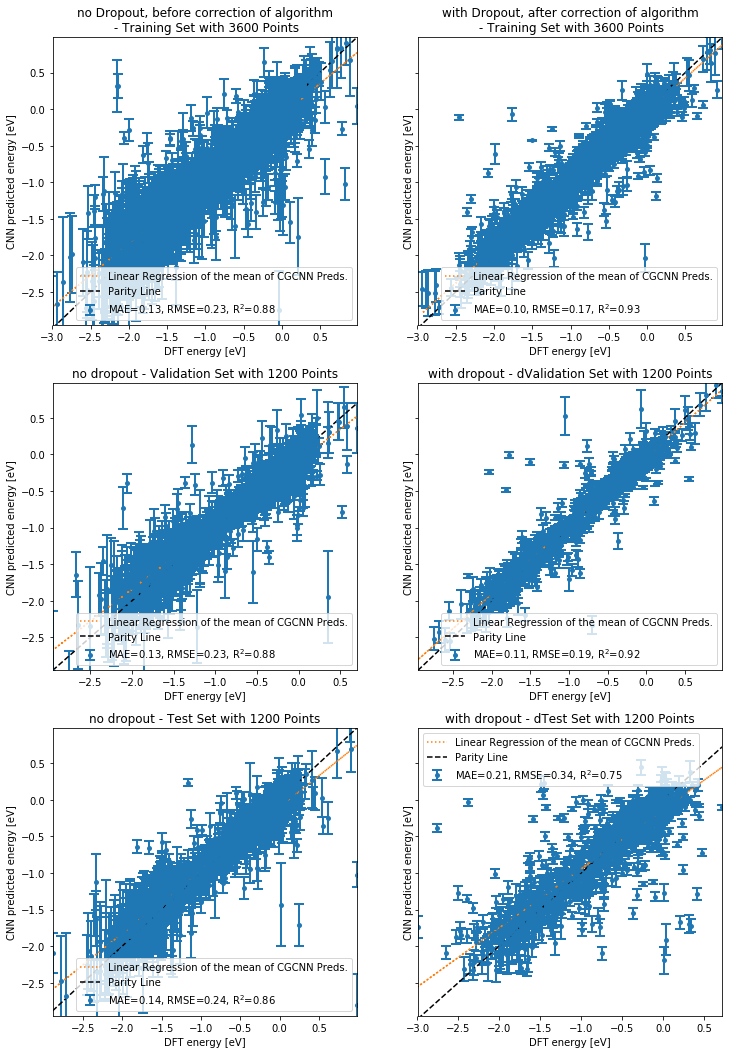

In [4]:
trslope, trintercept, trr_value, trp_value, trstd_err = stats.linregress(TrainingData.iloc[:, 0],
                                                                         TrainingStats['mean'])
tsslope, tsintercept, tsr_value, tsp_value, tsstd_err = stats.linregress(TestData.iloc[:, 0],
                                                                         TestStats['mean'])
vlslope, vlintercept, vlr_value, vlp_value, vlstd_err = stats.linregress(ValidationData.iloc[:, 0],
                                                                         ValidationStats['mean'])
dtrslope, dtrintercept, dtrr_value, dtrp_value, dtrstd_err = stats.linregress(dTrainingData.iloc[:, 0],
                                                                              dTrainingStats['mean'])
dtsslope, dtsintercept, dtsr_value, dtsp_value, dtsstd_err = stats.linregress(dTestData.iloc[:, 0],
                                                                              dTestStats['mean'])
dvlslope, dvlintercept, dvlr_value, dvlp_value, dvlstd_err = stats.linregress(dValidationData.iloc[:, 0],
                                                                              dValidationStats['mean'])

f, axs2 = plt.subplots(3, 2, figsize=(12, 18), sharey=True)
ax2a, ax2d, ax2c, ax2f, ax2b, ax2e  = axs2.flatten()

trainmean = TrainingData.iloc[:, 0]
testmean = TestData.iloc[:, 0]
Validationmean = ValidationData.iloc[:, 0]
dtrainmean = TrainingData.iloc[:, 0]
dtestmean = dTestData.iloc[:, 0]
dValidationmean = dValidationData.iloc[:, 0]

ax2a.errorbar(TrainingData.iloc[:, 0], TrainingStats['mean'],
             yerr=TrainingStats['std'],
             # lolims=True, uplims=True,
             capsize=5, elinewidth=2, markeredgewidth=2,
             linestyle='', marker='.',
             label='MAE=%0.2f, RMSE=%0.2f, R$^2$=%0.2f'\
             %(mean_absolute_error(TrainingData.iloc[:, 0], TrainingStats['mean']), 
               np.sqrt(mean_squared_error(TrainingData.iloc[:, 0], TrainingStats['mean'])),
               r2_score(TrainingData.iloc[:, 0], TrainingStats['mean'])))

ax2a.plot(TrainingData.iloc[:, 0], TrainingData.iloc[:, 0]*trslope+trintercept, linestyle=':',
         label='Linear Regression of the mean of CGCNN Preds.')

ax2a.plot([min(trainmean), max(trainmean)], 
         [min(trainmean), max(trainmean)], 'k--', label='Parity Line')

ax2a.set_xlabel('DFT energy [eV]')
ax2a.set_ylabel('CNN predicted energy [eV]')
ax2a.set_title('no Dropout, before correction of algorithm\n - Training Set with 3600 Points')
ax2a.set_xlim((min(trainmean), max(trainmean)))
ax2a.set_ylim((min(trainmean), max(trainmean)))
ax2a.legend()

ax2b.errorbar(TestData.iloc[:, 0], TestStats['mean'],
             yerr=TestStats['std'],
             # lolims=True, uplims=True,
             capsize=5, elinewidth=2, markeredgewidth=2,
             linestyle='', marker='.',
             label='MAE=%0.2f, RMSE=%0.2f, R$^2$=%0.2f'\
             %(mean_absolute_error(TestData.iloc[:, 0], TestStats['mean']), 
               np.sqrt(mean_squared_error(TestData.iloc[:, 0], TestStats['mean'])),
               r2_score(TestData.iloc[:, 0], TestStats['mean'])))
ax2b.plot(TestData.iloc[:, 0], TestData.iloc[:, 0]*tsslope+tsintercept, linestyle=':',
         label='Linear Regression of the mean of CGCNN Preds.')
ax2b.plot([min(testmean), max(testmean)], 
         [min(testmean), max(testmean)], 'k--', label='Parity Line')

ax2b.set_xlabel('DFT energy [eV]')
ax2b.set_ylabel('CNN predicted energy [eV]')
ax2b.set_title('no dropout - Test Set with 1200 Points')
ax2b.set_xlim((min(testmean), max(testmean)))
ax2b.set_ylim((min(testmean), max(testmean)))
ax2b.legend()

ax2c.errorbar(ValidationData.iloc[:, 0], ValidationStats['mean'],
             yerr=ValidationStats['std'],
             # lolims=True, uplims=True,
             capsize=5, elinewidth=2, markeredgewidth=2,
             linestyle='', marker='.',
             label='MAE=%0.2f, RMSE=%0.2f, R$^2$=%0.2f'\
             %(mean_absolute_error(ValidationData.iloc[:, 0], ValidationStats['mean']), 
               np.sqrt(mean_squared_error(ValidationData.iloc[:, 0], ValidationStats['mean'])),
               r2_score(ValidationData.iloc[:, 0], ValidationStats['mean'])))
ax2c.plot(ValidationData.iloc[:, 0], ValidationData.iloc[:, 0]*vlslope+vlintercept, linestyle=':',
         label='Linear Regression of the mean of CGCNN Preds.')
ax2c.plot([min(Validationmean), max(Validationmean)], 
         [min(Validationmean), max(Validationmean)], 'k--', label='Parity Line')

ax2c.set_xlabel('DFT energy [eV]')
ax2c.set_ylabel('CNN predicted energy [eV]')
ax2c.set_title('no dropout - Validation Set with 1200 Points')
ax2c.set_xlim((min(Validationmean), max(Validationmean)))
ax2c.set_ylim((min(Validationmean), max(Validationmean)))
ax2c.legend()

ax2d.errorbar(dTrainingData.iloc[:, 0], dTrainingStats['mean'],
             yerr=dTrainingStats['std'],
             # lolims=True, uplims=True,
             capsize=5, elinewidth=2, markeredgewidth=2,
             linestyle='', marker='.',
             label='MAE=%0.2f, RMSE=%0.2f, R$^2$=%0.2f'\
             %(mean_absolute_error(dTrainingData.iloc[:, 0], dTrainingStats['mean']), 
               np.sqrt(mean_squared_error(dTrainingData.iloc[:, 0], dTrainingStats['mean'])),
               r2_score(dTrainingData.iloc[:, 0], dTrainingStats['mean'])))

ax2d.plot(dTrainingData.iloc[:, 0], dTrainingData.iloc[:, 0]*dtrslope+dtrintercept, linestyle=':',
         label='Linear Regression of the mean of CGCNN Preds.')
         
ax2d.plot([min(dtrainmean), max(dtrainmean)], 
         [min(dtrainmean), max(dtrainmean)], 'k--', label='Parity Line')

ax2d.set_xlabel('DFT energy [eV]')
ax2d.set_ylabel('CNN predicted energy [eV]')
ax2d.set_title('with Dropout, after correction of algorithm\n - Training Set with 3600 Points')
ax2d.set_xlim((min(dtrainmean), max(dtrainmean)))
ax2d.set_ylim((min(dtrainmean), max(dtrainmean)))
ax2d.legend()

ax2e.errorbar(dTestData.iloc[:, 0], dTestStats['mean'],
             yerr=dTestStats['std'],
             # lolims=True, uplims=True,
             capsize=5, elinewidth=2, markeredgewidth=2,
             linestyle='', marker='.',
             label='MAE=%0.2f, RMSE=%0.2f, R$^2$=%0.2f'\
             %(mean_absolute_error(dTestData.iloc[:, 0], dTestStats['mean']), 
               np.sqrt(mean_squared_error(dTestData.iloc[:, 0], dTestStats['mean'])),
               r2_score(dTestData.iloc[:, 0], dTestStats['mean'])))
ax2e.plot(dTestData.iloc[:, 0], dTestData.iloc[:, 0]*dtsslope+dtsintercept, linestyle=':',
         label='Linear Regression of the mean of CGCNN Preds.')
ax2e.plot([min(dtestmean), max(dtestmean)], 
         [min(dtestmean), max(dtestmean)], 'k--', label='Parity Line')

ax2e.set_xlabel('DFT energy [eV]')
ax2e.set_ylabel('CNN predicted energy [eV]')
ax2e.set_title('with dropout - dTest Set with 1200 Points')
ax2e.set_xlim((min(dtestmean), max(dtestmean)))
ax2e.set_ylim((min(dtestmean), max(dtestmean)))
ax2e.legend()

ax2f.errorbar(dValidationData.iloc[:, 0], dValidationStats['mean'],
             yerr=dValidationStats['std'],
             # lolims=True, uplims=True,
             capsize=5, elinewidth=2, markeredgewidth=2,
             linestyle='', marker='.',
             label='MAE=%0.2f, RMSE=%0.2f, R$^2$=%0.2f'\
             %(mean_absolute_error(dValidationData.iloc[:, 0], dValidationStats['mean']), 
               np.sqrt(mean_squared_error(dValidationData.iloc[:, 0], dValidationStats['mean'])),
               r2_score(dValidationData.iloc[:, 0], dValidationStats['mean'])))
ax2f.plot(dValidationData.iloc[:, 0], dValidationData.iloc[:, 0]*dvlslope+dvlintercept, linestyle=':',
         label='Linear Regression of the mean of CGCNN Preds.')
ax2f.plot([min(dValidationmean), max(dValidationmean)], 
         [min(dValidationmean), max(dValidationmean)], 'k--', label='Parity Line')

ax2f.set_xlabel('DFT energy [eV]')
ax2f.set_ylabel('CNN predicted energy [eV]')
ax2f.set_title('with dropout - dValidation Set with 1200 Points')
ax2f.set_xlim((min(dValidationmean), max(dValidationmean)))
ax2f.set_ylim((min(dValidationmean), max(dValidationmean)))
ax2f.legend()

plt.show()

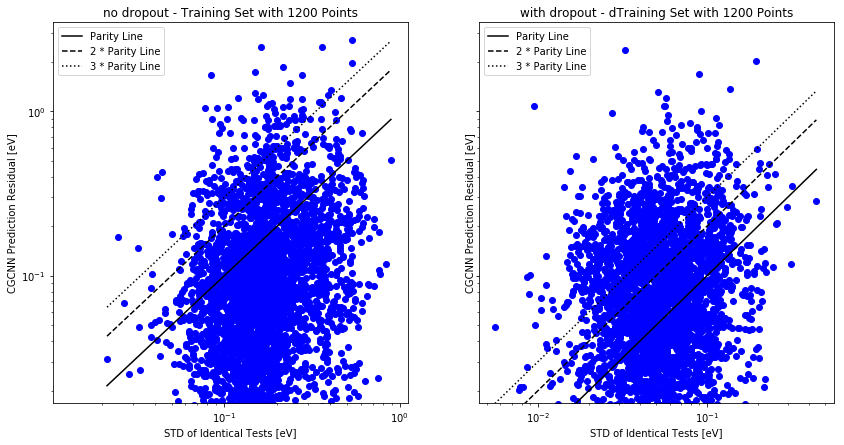

In [8]:
TrainingResid = np.abs(TrainingData.iloc[:, 0] - TrainingStats['mean'])
dTrainingResid = np.abs(dTrainingData.iloc[:, 0] - dTrainingStats['mean'])

# std = TrainingStats['std']
# dstd = dTrainingStats['std']

f, (ax4a, ax4b) = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
ax4a.scatter(TrainingStats['std'], TrainingResid, color='blue')
ax4a.plot([min(TrainingStats['std']), max(TrainingStats['std'])], 
         [min(TrainingStats['std']), max(TrainingStats['std'])], 'k', label='Parity Line')
ax4a.plot([min(TrainingStats['std']), max(TrainingStats['std'])], 
         [2 * min(TrainingStats['std']), 2 * max(TrainingStats['std'])], 'k--', label='2 * Parity Line')
ax4a.plot([min(TrainingStats['std']), max(TrainingStats['std'])], 
         [3 * min(TrainingStats['std']), 3 * max(TrainingStats['std'])], 'k:', label='3 * Parity Line')

ax4a.set_xlabel('STD of Identical Tests [eV]')
ax4a.set_ylabel('CGCNN Prediction Residual [eV]')
ax4a.set_xscale('log')
ax4a.set_yscale('log')
ax4a.set_title('no dropout - Training Set with 1200 Points')
ax4a.legend()


ax4b.scatter(dTrainingStats['std'], dTrainingResid, color='blue')
ax4b.plot([min(dTrainingStats['std']), max(dTrainingStats['std'])], 
         [min(dTrainingStats['std']), max(dTrainingStats['std'])], 'k', label='Parity Line')
ax4b.plot([min(dTrainingStats['std']), max(dTrainingStats['std'])], 
         [2 * min(dTrainingStats['std']), 2 * max(dTrainingStats['std'])], 'k--', label='2 * Parity Line')
ax4b.plot([min(dTrainingStats['std']), max(dTrainingStats['std'])], 
         [3 * min(dTrainingStats['std']), 3 * max(dTrainingStats['std'])], 'k:', label='3 * Parity Line')

ax4b.set_xlabel('STD of Identical Tests [eV]')
ax4b.set_ylabel('CGCNN Prediction Residual [eV]')
ax4b.set_xscale('log')
ax4b.set_yscale('log')
ax4b.set_title('with dropout - dTraining Set with 1200 Points')
ax4b.legend()

plt.show()

Note: Parity plots like these are not sufficiently helpful.

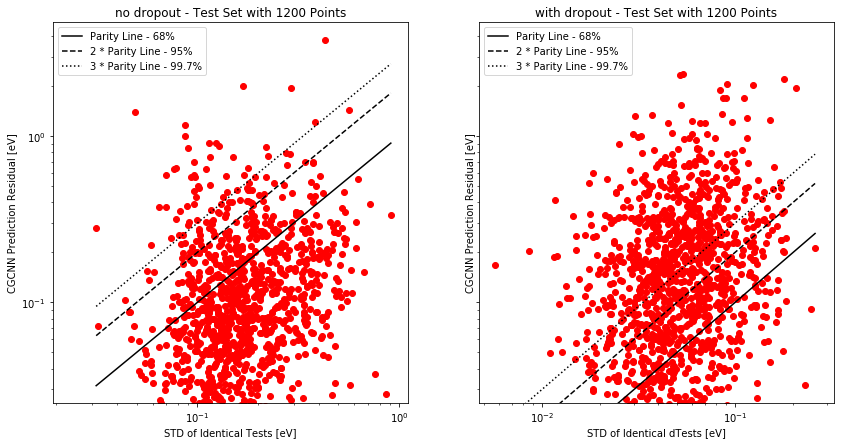

In [9]:
TestResid = np.abs(TestData.iloc[:, 0] - TestStats['mean'])
dTestResid = np.abs(dTestData.iloc[:, 0] - dTestStats['mean'])
# std = TestStats['std']
# dstd = dTestStats['std']

f, (ax5a, ax5b) = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

ax5a.scatter(TestStats['std'], TestResid, color='red')
ax5a.plot([min(TestStats['std']), max(TestStats['std'])], 
         [min(TestStats['std']), max(TestStats['std'])], 'k', label='Parity Line - 68%')
ax5a.plot([min(TestStats['std']), max(TestStats['std'])], 
         [2 * min(TestStats['std']), 2 * max(TestStats['std'])], 'k--', label='2 * Parity Line - 95%')
ax5a.plot([min(TestStats['std']), max(TestStats['std'])], 
         [3 * min(TestStats['std']), 3 * max(TestStats['std'])], 'k:', label='3 * Parity Line - 99.7%')

ax5a.set_xlabel('STD of Identical Tests [eV]')
ax5a.set_ylabel('CGCNN Prediction Residual [eV]')
ax5a.set_xscale('log')
ax5a.set_yscale('log')
ax5a.set_title('no dropout - Test Set with 1200 Points')
ax5a.legend()


ax5b.scatter(dTestStats['std'], dTestResid, color='red')
ax5b.plot([min(dTestStats['std']), max(dTestStats['std'])], 
         [min(dTestStats['std']), max(dTestStats['std'])], 'k', label='Parity Line - 68%')
ax5b.plot([min(dTestStats['std']), max(dTestStats['std'])], 
         [2 * min(dTestStats['std']), 2 * max(dTestStats['std'])], 'k--', label='2 * Parity Line - 95%')
ax5b.plot([min(dTestStats['std']), max(dTestStats['std'])], 
         [3 * min(dTestStats['std']), 3 * max(dTestStats['std'])], 'k:', label='3 * Parity Line - 99.7%')

ax5b.set_xlabel('STD of Identical dTests [eV]')
ax5b.set_ylabel('CGCNN Prediction Residual [eV]')
ax5b.set_xscale('log')
ax5b.set_yscale('log')
ax5b.set_title('with dropout - Test Set with 1200 Points')
ax5b.legend()

plt.show()

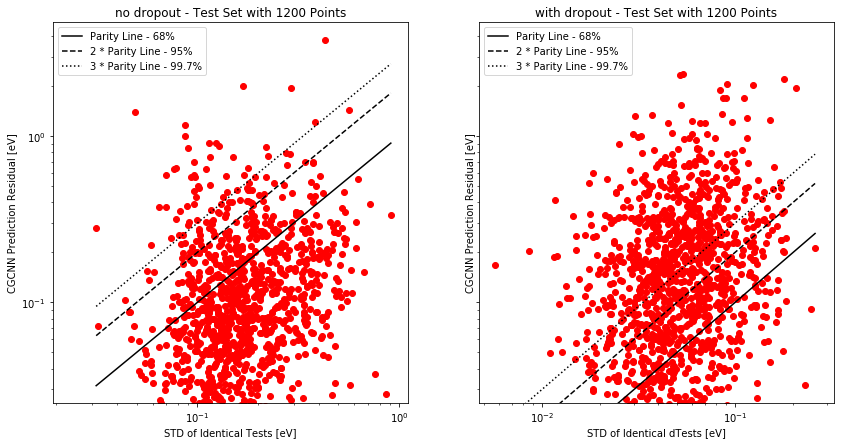

In [10]:
f, (ax6a, ax6b) = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

ax6a.scatter(TestStats['std'], TestResid, color='red')
ax6a.plot([min(TestStats['std']), max(TestStats['std'])], 
         [min(TestStats['std']), max(TestStats['std'])], 'k', label='Parity Line - 68%')
ax6a.plot([min(TestStats['std']), max(TestStats['std'])], 
         [2 * min(TestStats['std']), 2 * max(TestStats['std'])], 'k--', label='2 * Parity Line - 95%')
ax6a.plot([min(TestStats['std']), max(TestStats['std'])], 
         [3 * min(TestStats['std']), 3 * max(TestStats['std'])], 'k:', label='3 * Parity Line - 99.7%')

ax6a.set_xlabel('STD of Identical Tests [eV]')
ax6a.set_ylabel('CGCNN Prediction Residual [eV]')
ax6a.set_xscale('log')
ax6a.set_yscale('log')
ax6a.set_title('no dropout - Test Set with 1200 Points')
ax6a.legend()


ax6b.scatter(dTestStats['std'], dTestResid, color='red')
ax6b.plot([min(dTestStats['std']), max(dTestStats['std'])], 
         [min(dTestStats['std']), max(dTestStats['std'])], 'k', label='Parity Line - 68%')
ax6b.plot([min(dTestStats['std']), max(dTestStats['std'])], 
         [2 * min(dTestStats['std']), 2 * max(dTestStats['std'])], 'k--', label='2 * Parity Line - 95%')
ax6b.plot([min(dTestStats['std']), max(dTestStats['std'])], 
         [3 * min(dTestStats['std']), 3 * max(dTestStats['std'])], 'k:', label='3 * Parity Line - 99.7%')

ax6b.set_xlabel('STD of Identical dTests [eV]')
ax6b.set_ylabel('CGCNN Prediction Residual [eV]')
ax6b.set_xscale('log')
ax6b.set_yscale('log')
ax6b.set_title('with dropout - Test Set with 1200 Points')
ax6b.legend()

plt.show()

In [22]:
CalibrationCurve = pd.concat([TestStats['std'], TestResid], axis=1)
CalibrationCurve.columns = ['std', 'resid']
# CalibrationCurve = CalibrationCurve.sort_values(['std', 'resid'], ascending=[0, 1])

dCalibrationCurve = pd.concat([dTestStats['std'], dTestResid], axis=1)
dCalibrationCurve.columns = ['std', 'resid']
# dCalibrationCurve = dCalibrationCurve.sort_values(['std', 'resid'], ascending=[1, 0])

In [23]:
# CalibrationCurve['std'] = CalibrationCurve['std'] / max(CalibrationCurve['std'])
# CalibrationCurve['resid'] = CalibrationCurve['resid'] / max(CalibrationCurve['resid'])

CalibrationCurveCum = CalibrationCurve.cumsum()
CalibrationCurveCum = CalibrationCurveCum / CalibrationCurveCum.max()

print(CalibrationCurve)
print(CalibrationCurveCum)

           std     resid
0     0.330675  0.215556
1     0.085936  0.048415
2     0.142370  0.077674
3     0.114361  0.002912
4     0.236217  0.331196
5     0.288445  0.002974
6     0.135208  0.070065
7     0.243587  0.118288
8     0.165491  0.057243
9     0.285757  0.067921
10    0.435705  0.071662
11    0.110074  0.636301
12    0.145290  0.186087
13    0.226333  0.009117
14    0.078608  0.014876
15    0.185795  0.330398
16    0.055859  0.049275
17    0.193692  0.203191
18    0.102206  0.276071
19    0.111354  0.071329
20    0.091092  0.021850
21    0.059518  0.037675
22    0.161000  0.138753
23    0.149694  0.011894
24    0.313955  0.120630
25    0.193485  0.136450
26    0.091501  0.201790
27    0.301963  0.105643
28    0.468566  0.001500
29    0.076555  0.067672
...        ...       ...
1170  0.093877  0.216021
1171  0.125982  0.059330
1172  0.129030  0.045733
1173  0.110501  0.019542
1174  0.375220  0.399216
1175  0.226185  0.036601
1176  0.329200  0.275191
1177  0.188515  0.383401


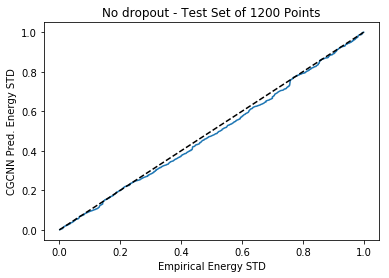

In [24]:
plt.plot(CalibrationCurveCum['std'], CalibrationCurveCum['resid'])
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('Empirical Energy STD')
plt.ylabel('CGCNN Pred. Energy STD')
plt.title('No dropout - Test Set of 1200 Points')

plt.show()

In [ ]:
CalibrationCurveRolling